In [1]:
# pip install myocr

In [2]:
# pip install pdf2image pillow

In [3]:
from myocr import Project
debug=False
project_name ='demo_project'
pdf_path = "demo_input.pdf"
my_class={
    0:'miss',
    1:'check',
    2:'cancel'
}
p=Project(project_name,my_class)




Initializing project:
Data deserialized and cast to original types from demo_project/config.json
Project config:
{'cropped_dir': PosixPath('/home/wasit/Desktop/myocr/image-server/dataset/images/demo_project'),
 'landing_dir': PosixPath('/home/wasit/Desktop/myocr/notebooks/demo_project/_landing'),
 'project_name': 'demo_project',
 'staging_dir': PosixPath('/home/wasit/Desktop/myocr/notebooks/demo_project/_staging')}


# 1.Convert PDF to images

In [4]:
from pdf2image import convert_from_path
import os

def pdf_to_images(pdf_path, output_folder, dpi=300):
    """
    Convert each page of a PDF into separate image files.

    Parameters:
    - pdf_path: str, path to the input PDF file.
    - output_folder: str, directory where the images should be saved.
    - dpi: int, optional, DPI setting for the output images.

    Returns:
    - A list of paths to the saved image files.
    """
    # Ensure the output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Convert PDF pages to images
    images = convert_from_path(pdf_path, dpi=dpi)

    # Save each page as an image
    image_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f"page{i + 1:03d}.png")
        image.save(image_path, "PNG")
        image_paths.append(image_path)
    
    return image_paths

# Example Usage
# pdf_path = "dsi310_2024_raw.pdf"
output_folder = p.landing_dir
image_paths = pdf_to_images(pdf_path, output_folder)

# Print the saved image paths
for img_path in image_paths:
    print(f"Saved: {img_path}")


Saved: /home/wasit/Desktop/myocr/notebooks/demo_project/_landing/page001.png


# 2.Registaer all images

In [5]:
ref_path='ref.png'
reference_image = p.set_reference_image('ref.png')
p.register_image(debug)


Register_image:
/home/wasit/Desktop/myocr/notebooks/demo_project/_landing/page001.png
/home/wasit/Desktop/myocr/notebooks/demo_project/_staging/page001.png


# 3.Create BBox template

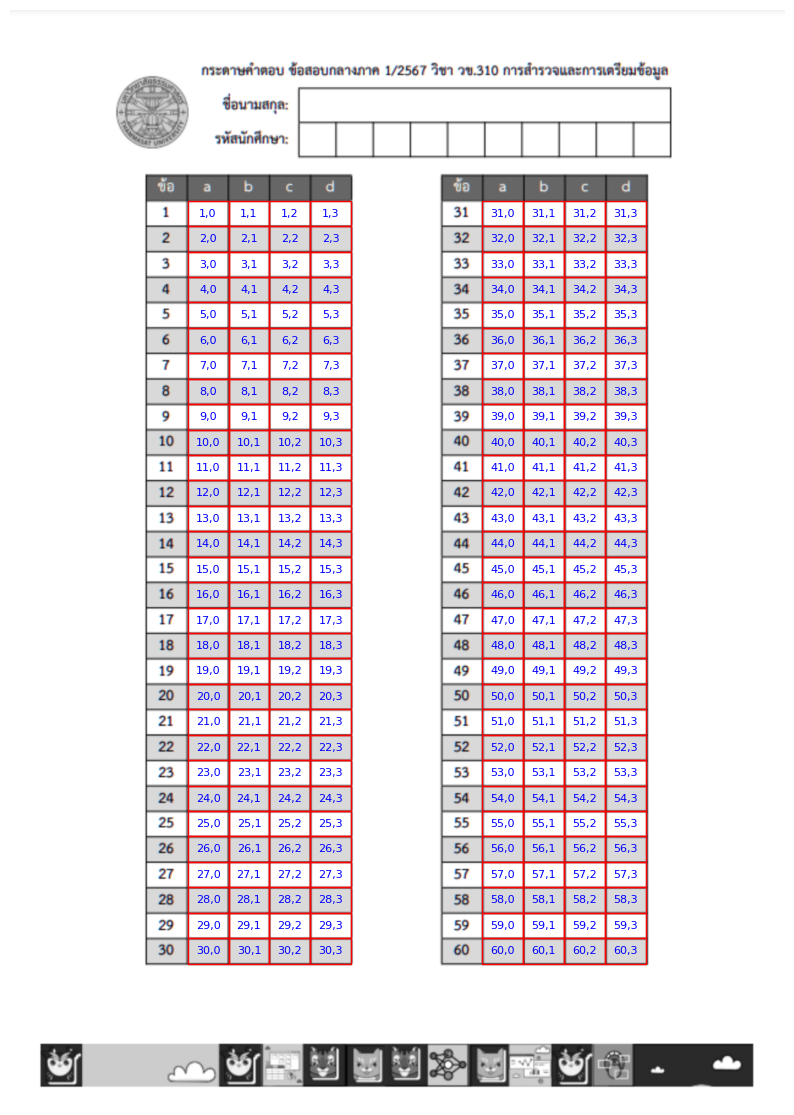

In [6]:
# Define the bounding box dimensions
box_width = 33.5*2  # approximate width of each choice box
box_height = 20.8*2  # approximate height of each question row

# Coordinates for the left column (questions 1-30)
left_column_start_x = 145*2
left_column_start_y = 156*2

# Coordinates for the right column (questions 31-60)
right_column_start_x = 386*2
right_column_start_y = 156*2

all_bbox=[]   
    
# Draw bounding boxes for the left column (questions 1-30)
for i in range(30):
    for c, choice in enumerate(['a', 'b', 'c', 'd']):
        q=i+1
        x = left_column_start_x + c * box_width  # Each choice moves right by box_width
        y = left_column_start_y + i * box_height  # Each question moves down by box_height
        d={
            'q':q,
            'c':c,
            'x':x,
            'y':y,
            'box_width': box_width, 
            'box_height': box_height
        }
        all_bbox.append(d)
        # print(d)
        # save_cropped_bbox(image,sheet_name, q + 1, choice, x, y, box_width, box_height)

# Draw bounding boxes for the right column (questions 31-60)
for i in range(30):
    for c, choice in enumerate(['a', 'b', 'c', 'd']):
        q=i+31
        x = right_column_start_x + c * box_width  # Each choice moves right by box_width
        y = right_column_start_y + i* box_height  # Each question moves down by box_height
        d={
            'q':q,
            'c':c,
            'x':x,
            'y':y,
            'box_width': box_width, 
            'box_height': box_height
        }
        all_bbox.append(d)
        # print(d)
        # save_cropped_bbox(image,sheet_name, q + 1, choice, x, y, box_width, box_height)
    
p.draw_all_bbox(reference_image,all_bbox)

In [7]:
p.extract_bb(all_bbox, debug)


Extract_image:
image_path:  /home/wasit/Desktop/myocr/notebooks/demo_project/_staging/page001.png
sheet_name:  page001
bbox:  [{'q': 1, 'c': 0, 'x': 290.0, 'y': 312.0, 'box_width': 67.0, 'box_height': 41.6, 's': 'page001'}, {'


# 4.Forword

In [8]:
import torchvision.transforms as transforms
from myocr import ImageClassifier
from pathlib import Path
import pandas as pd

num_classes=len(p.my_class)

input_image_size = (32, 32)
transform = transforms.Compose([
    transforms.Resize(input_image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
model_name='lenet'
classifier = ImageClassifier(model_name, num_classes, input_image_size, transform)

pre_train = '_lenet_13200_100.pth'
if Path(pre_train).exists():
    classifier.load(pre_train)

def as_series(func):
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return pd.Series(result)
    return wrapper
    
@as_series
def forward(image):
    class_id, confidence = classifier.predict(image)
    return class_id, confidence

# Apply the function to each row and create 'y1' and 'y2' columns
df = p.get_input_df()
df[['predict', 'confidence']] = df.apply(lambda row: forward(row['PIL_image']), axis=1)
df.info()
df.head()

Model and hyperparameters loaded from _lenet_13200_100.pth


/home/wasit/miniconda3/envs/myocr/lib/python3.10/site-packages/myocr/vision.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   project_name  240 non-null    object 
 1   image_file    240 non-null    object 
 2   sheet         240 non-null    object 
 3   question      240 non-null    object 
 4   choice        240 non-null    object 
 5   PIL_image     240 non-null    object 
 6   image_url     240 non-null    object 
 7   predict       240 non-null    float64
 8   confidence    240 non-null    float64
dtypes: float64(2), object(7)
memory usage: 17.0+ KB


,project_name,image_file,sheet,question,choice,PIL_image,image_url,predict,confidence
0,demo_project,B_page001_23_2.jpg,page001,23,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/demo_project/B_page001_2...,0.0,0.999965
1,demo_project,B_page001_54_2.jpg,page001,54,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/demo_project/B_page001_5...,0.0,1.000000
2,demo_project,B_page001_54_3.jpg,page001,54,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/demo_project/B_page001_5...,1.0,0.999976
3,demo_project,B_page001_29_0.jpg,page001,29,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/demo_project/B_page001_2...,1.0,1.000000
4,demo_project,B_page001_38_3.jpg,page001,38,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/demo_project/B_page001_3...,0.0,0.999938


In [9]:
df2=df[['sheet','question','choice','predict','confidence']].copy()
df2=df2.astype({'question':'int64'})
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sheet       240 non-null    object 
 1   question    240 non-null    int64  
 2   choice      240 non-null    object 
 3   predict     240 non-null    float64
 4   confidence  240 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.5+ KB


,sheet,question,choice,predict,confidence
0,page001,23,2,0.0,0.999965
1,page001,54,2,0.0,1.000000
2,page001,54,3,1.0,0.999976
3,page001,29,0,1.0,1.000000
4,page001,38,3,0.0,0.999938


In [10]:
# df2[(df2['sheet']=='page047') & (df2['question']==52) & (df2['choice']==0)].iloc[0,-2]

# 5.Render Result

In [11]:
# all_bbox

Rendering Results:
image_path:  /home/wasit/Desktop/myocr/notebooks/demo_project/_staging/page001.png
sheet_name:  page001


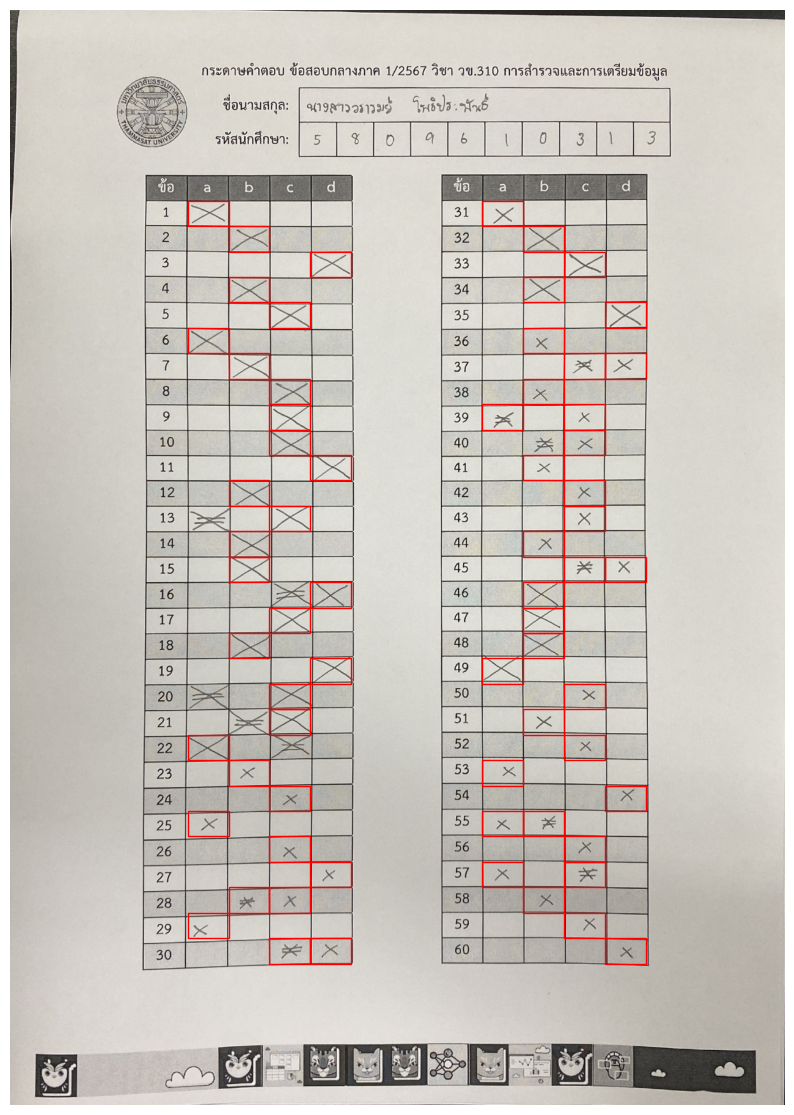

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print('Rendering Results:')
image_files = p.find_all_images(p.staging_dir)
result_dir = (p.project_dir/f'_result').resolve()
result_dir.mkdir(parents=True, exist_ok=True)

for i,image in enumerate(image_files):
    sheet_all_bbox=[]
    image_path = Path(p.staging_dir)/image
    sheet_name = image.split('.')[0] 
    print("image_path: ",image_path)
    print("sheet_name: ",sheet_name)
    image = Image.open(image_path)

    fig, ax = plt.subplots(figsize=(10, 15))
    for i in all_bbox:
        # self.draw_bbox(ax, **i)
        q, c, x, y, box_width, box_height = i['q'], i['c'], i['x'], i['y'], i['box_width'], i['box_height']
        is_check = df2[(df2['sheet']==sheet_name) & (df2['question']==q) & (df2['choice']==str(c))].iloc[0,-2]==1
        if is_check:
        # label = f'{q},{c}'
            rect = patches.Rectangle((x, y), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        # ax.text(x + box_width / 2, y + box_height / 2, label, fontsize=8, color='blue', ha='center', va='center')
    # Display the image
    ax.imshow(image)
    # Show the result with bounding boxes
    plt.axis('off')  # Hide the axes for better visualization
    # plt.show()
    
    plt.savefig(result_dir/f'{sheet_name}.png', format='png', dpi=80, bbox_inches='tight')
# plt.close()

# 6.Export File

In [18]:
def get_ans(c1,c2,c3,c4):
    a=(c1==1)
    b=(c2==1)
    c=(c3==1)
    d=(c4==1)
    if (a) and (not b) and (not c) and (not d):
        return 'a'
    elif (not a) and (b) and (not c) and (not d):
        return 'b'
    elif (not a) and (not b) and (c) and (not d):
        return 'c'
    elif (not a) and (not b) and (not c) and (d):
        return 'd'
    else:
        return ''
        
df_pivot = pd.pivot_table(
    df2.reset_index(),
    index=['sheet', 'question'],
    columns=['choice'],
    aggfunc={'predict': "mean",'confidence': "mean"})
# df_pivot.info()
# df_pivot

# Flattening multi-level columns in df_pivot
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df3 = df_pivot.reset_index()

# df3.info()
# df3

df4=df3.copy()
df4['ans']=df4.apply(lambda row: get_ans(row['predict_0'],row['predict_1'],row['predict_2'],row['predict_3']), axis=1)
df4.info()
df4.to_csv( result_dir/(f'result_{p.project_name}.csv'))
df4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sheet         60 non-null     object 
 1   question      60 non-null     int64  
 2   confidence_0  60 non-null     float64
 3   confidence_1  60 non-null     float64
 4   confidence_2  60 non-null     float64
 5   confidence_3  60 non-null     float64
 6   predict_0     60 non-null     float64
 7   predict_1     60 non-null     float64
 8   predict_2     60 non-null     float64
 9   predict_3     60 non-null     float64
 10  ans           60 non-null     object 
dtypes: float64(8), int64(1), object(2)
memory usage: 5.3+ KB


,sheet,question,confidence_0,confidence_1,confidence_2,confidence_3,predict_0,predict_1,predict_2,predict_3,ans
0,page001,1,1.000000,0.999942,0.999971,1.000000,1.0,0.0,0.0,0.0,a
1,page001,2,0.998871,1.000000,0.999978,1.000000,0.0,1.0,0.0,0.0,b
2,page001,3,0.999932,0.999996,1.000000,1.000000,0.0,0.0,0.0,1.0,d
3,page001,4,0.999953,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,b
4,page001,5,0.999995,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,c
5,page001,6,1.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,a
6,page001,7,0.999977,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,b
7,page001,8,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,c
8,page001,9,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,c
9,page001,10,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,c


# Retrain the model
## Create Label Tasks

In [19]:
p.connect_label_studio()
p.create_task(forward)

Project 'demo_project' created successfully with ID: 1
<View>
    <Image name="image" value="$image" />
    <Choices name="choice" toName="image" showInLine="true">
        <Choice value="miss" /><Choice value="check" /><Choice value="cancel" /></Choices>
</View>


        create tasks:   0%|          | 0/240 [00:00<?, ?it/s]

  create annotations:   0%|          | 0/240 [00:00<?, ?it/s]

## Train

In [20]:
df_complete_task=p.lb.fetch_labels_from_label_studio()
# df_complete_task['image_file']=df_complete_task['image_url'].apply(lambda x: x.replace(lb.IMAGE_SERVER_URL+project_name+'/',''))
df_complete_task.info()
df_complete_task.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   task_id     240 non-null    int64 
 1   class_id    240 non-null    int64 
 2   class_name  240 non-null    object
 3   image_url   240 non-null    object
 4   image_file  240 non-null    object
dtypes: int64(2), object(3)
memory usage: 9.5+ KB


,task_id,class_id,class_name,image_url,image_file
0,1,0,miss,http://localhost:8000/demo_project/B_page001_2...,B_page001_23_2.jpg
1,2,0,miss,http://localhost:8000/demo_project/B_page001_5...,B_page001_54_2.jpg
2,3,1,check,http://localhost:8000/demo_project/B_page001_5...,B_page001_54_3.jpg
3,4,1,check,http://localhost:8000/demo_project/B_page001_2...,B_page001_29_0.jpg
4,5,0,miss,http://localhost:8000/demo_project/B_page001_3...,B_page001_38_3.jpg


Annotations saved to 'annotations.json'.


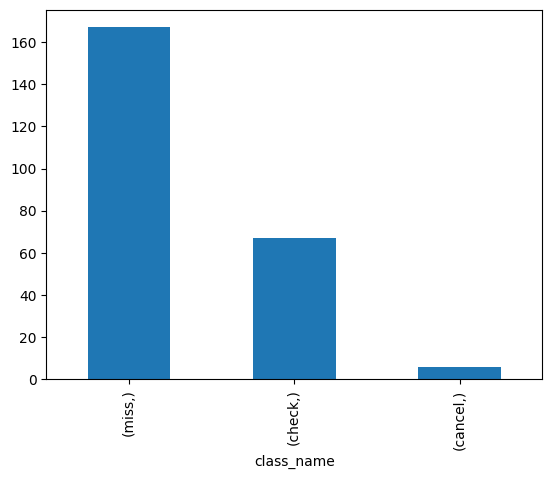

In [21]:
import json
df_complete_task[[ 'class_name']].value_counts().plot(kind='bar')
columns=['image_file','class_id']
annotation = {
    'annotations':df_complete_task[columns].to_dict('records'),
    'class_names':my_class
}
with open('annotations.json', 'w') as json_file:
    json.dump(annotation, json_file, indent=4)

print("Annotations saved to 'annotations.json'.")

In [22]:
from myocr import load_data
# Example Usage
annotations_file = 'annotations.json'  # Path to the JSON file with annotations
img_dir = p.cropped_dir  # Directory where the images are stored


augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Load the data with a custom train-test split, random seed, and data augmentation
train_loader, test_loader = load_data(annotations_file, img_dir, transform, augmentations, train_ratio=0.8, random_seed=42, batch_size=32)

# Train the model
classifier.train(train_loader, epochs=100)

# Evaluate the model
classifier.evaluate(test_loader)

# Save the model
classifier.save('lenet_retrained.pth')

Epoch [1/100], Loss: 0.0905
Epoch [11/100], Loss: 0.0195
Epoch [21/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0002
Epoch [41/100], Loss: 0.0002
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0001
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
Accuracy: 100.00%
Model and hyperparameters saved to lenet_retrained.pth
